In [ ]:
!pip install gdown

In [ ]:
import gdown

# Replace with your file ID
file_id = '1CKtywwQOsmJsd15Cz6axyVPGvqPluegD'
output = 'data.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Columns: ['trial_id', 'timestamp', 'range', 'goal_bias', 'rewire_factor', 'max_nearest_neighbors', 'delay_collision_checking', 'use_k_nearest', 'max_states', 'use_informed_sampling', 'sample_rejection_attempts', 'use_rejection_sampling', 'planning_time', 'path_length', 'success']
Numeric columns: ['trial_id', 'range', 'goal_bias', 'rewire_factor', 'max_nearest_neighbors', 'max_states', 'sample_rejection_attempts', 'planning_time', 'path_length']
Boolean columns: ['delay_collision_checking', 'use_k_nearest', 'use_informed_sampling', 'use_rejection_sampling', 'success']


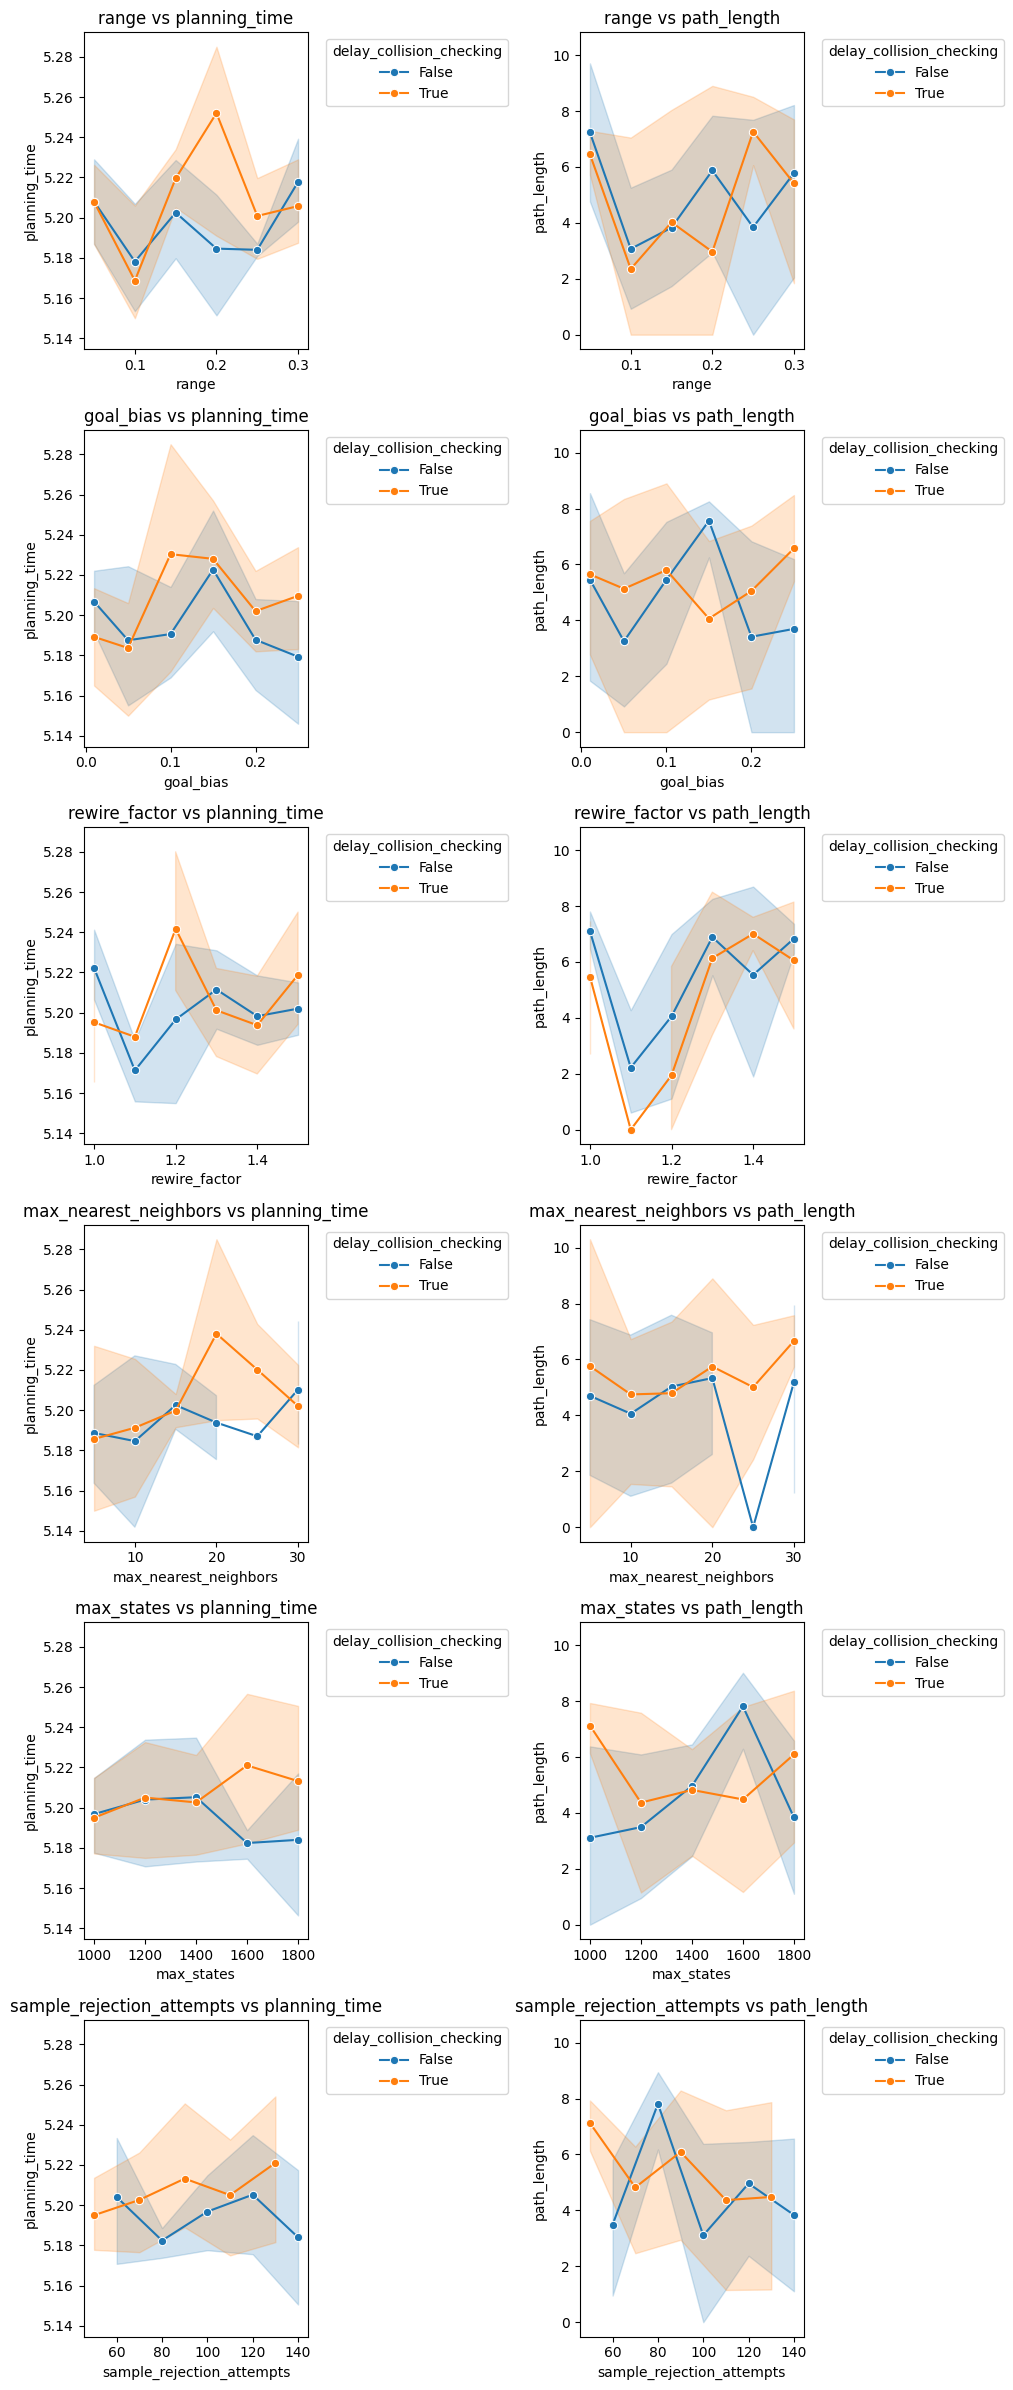

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_clean_csv(csv_file):
    """
    Robust CSV loader:
    - auto-detects comma vs tab delimiter
    - strips column names
    - converts TRUE/FALSE strings to booleans
    - separates numeric and boolean columns
    """
    # Try comma first
    try:
        df = pd.read_csv(csv_file, sep=",")
        if len(df.columns) == 1:  # maybe tab-separated
            df = pd.read_csv(csv_file, sep="\t")
    except Exception as e:
        raise ValueError(f"Error reading CSV: {e}")

    # Clean column names
    df.columns = df.columns.str.strip()

    # Convert TRUE/FALSE strings to booleans
    for col in df.columns:
        if df[col].dtype == object and df[col].isin(["TRUE", "FALSE"]).all():
            df[col] = df[col].map({"TRUE": True, "FALSE": False})

    # Detect numeric and boolean columns
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()

    print("Columns:", df.columns.tolist())
    print("Numeric columns:", numeric_cols)
    print("Boolean columns:", bool_cols)

    return df, numeric_cols, bool_cols

def plot_numeric_params_vs_goals(df, numeric_cols, bool_cols, metrics=["planning_time","path_length"]):
    """
    Grid of lineplots:
    - X-axis: numeric parameters
    - Y-axis: metrics
    - Hue: ONE selected boolean parameter at a time (for clarity)
    - Sorted x-axis
    - Legends outside plots
    """
    # Metrics that exist
    metrics = [m for m in metrics if m in numeric_cols]

    # Parameters = numeric columns that are not metrics or IDs
    exclude = ["trial_id", "timestamp"] + metrics
    params = [col for col in numeric_cols if col not in exclude]

    # Choose a boolean parameter to color by (for clarity)
    hue_col = bool_cols[0] if bool_cols else None  # e.g., use_informed_sampling

    # Setup grid
    fig, axes = plt.subplots(len(params), len(metrics), figsize=(12, 4*len(params)), sharey='col')
    if len(params) == 1:
        axes = [axes]

    for i, param in enumerate(params):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(params) > 1 else axes[j]

            subdf = df.sort_values(by=param)

            sns.lineplot(
                data=subdf,
                x=param,
                y=metric,
                hue=hue_col,
                marker="o",
                ax=ax,
                palette="tab10"
            )
            ax.set_title(f"{param} vs {metric}")
            ax.set_xlabel(param)
            ax.set_ylabel(metric)

            if hue_col:
                ax.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout(rect=[0,0,0.85,1])
    plt.show()



# ============================
# Example usage in notebook
# ============================

csv_file = "/content/data_t7.csv"  # path to your CSV

df, numeric_cols, bool_cols = load_and_clean_csv(csv_file)
plot_numeric_params_vs_goals(df, numeric_cols, bool_cols)



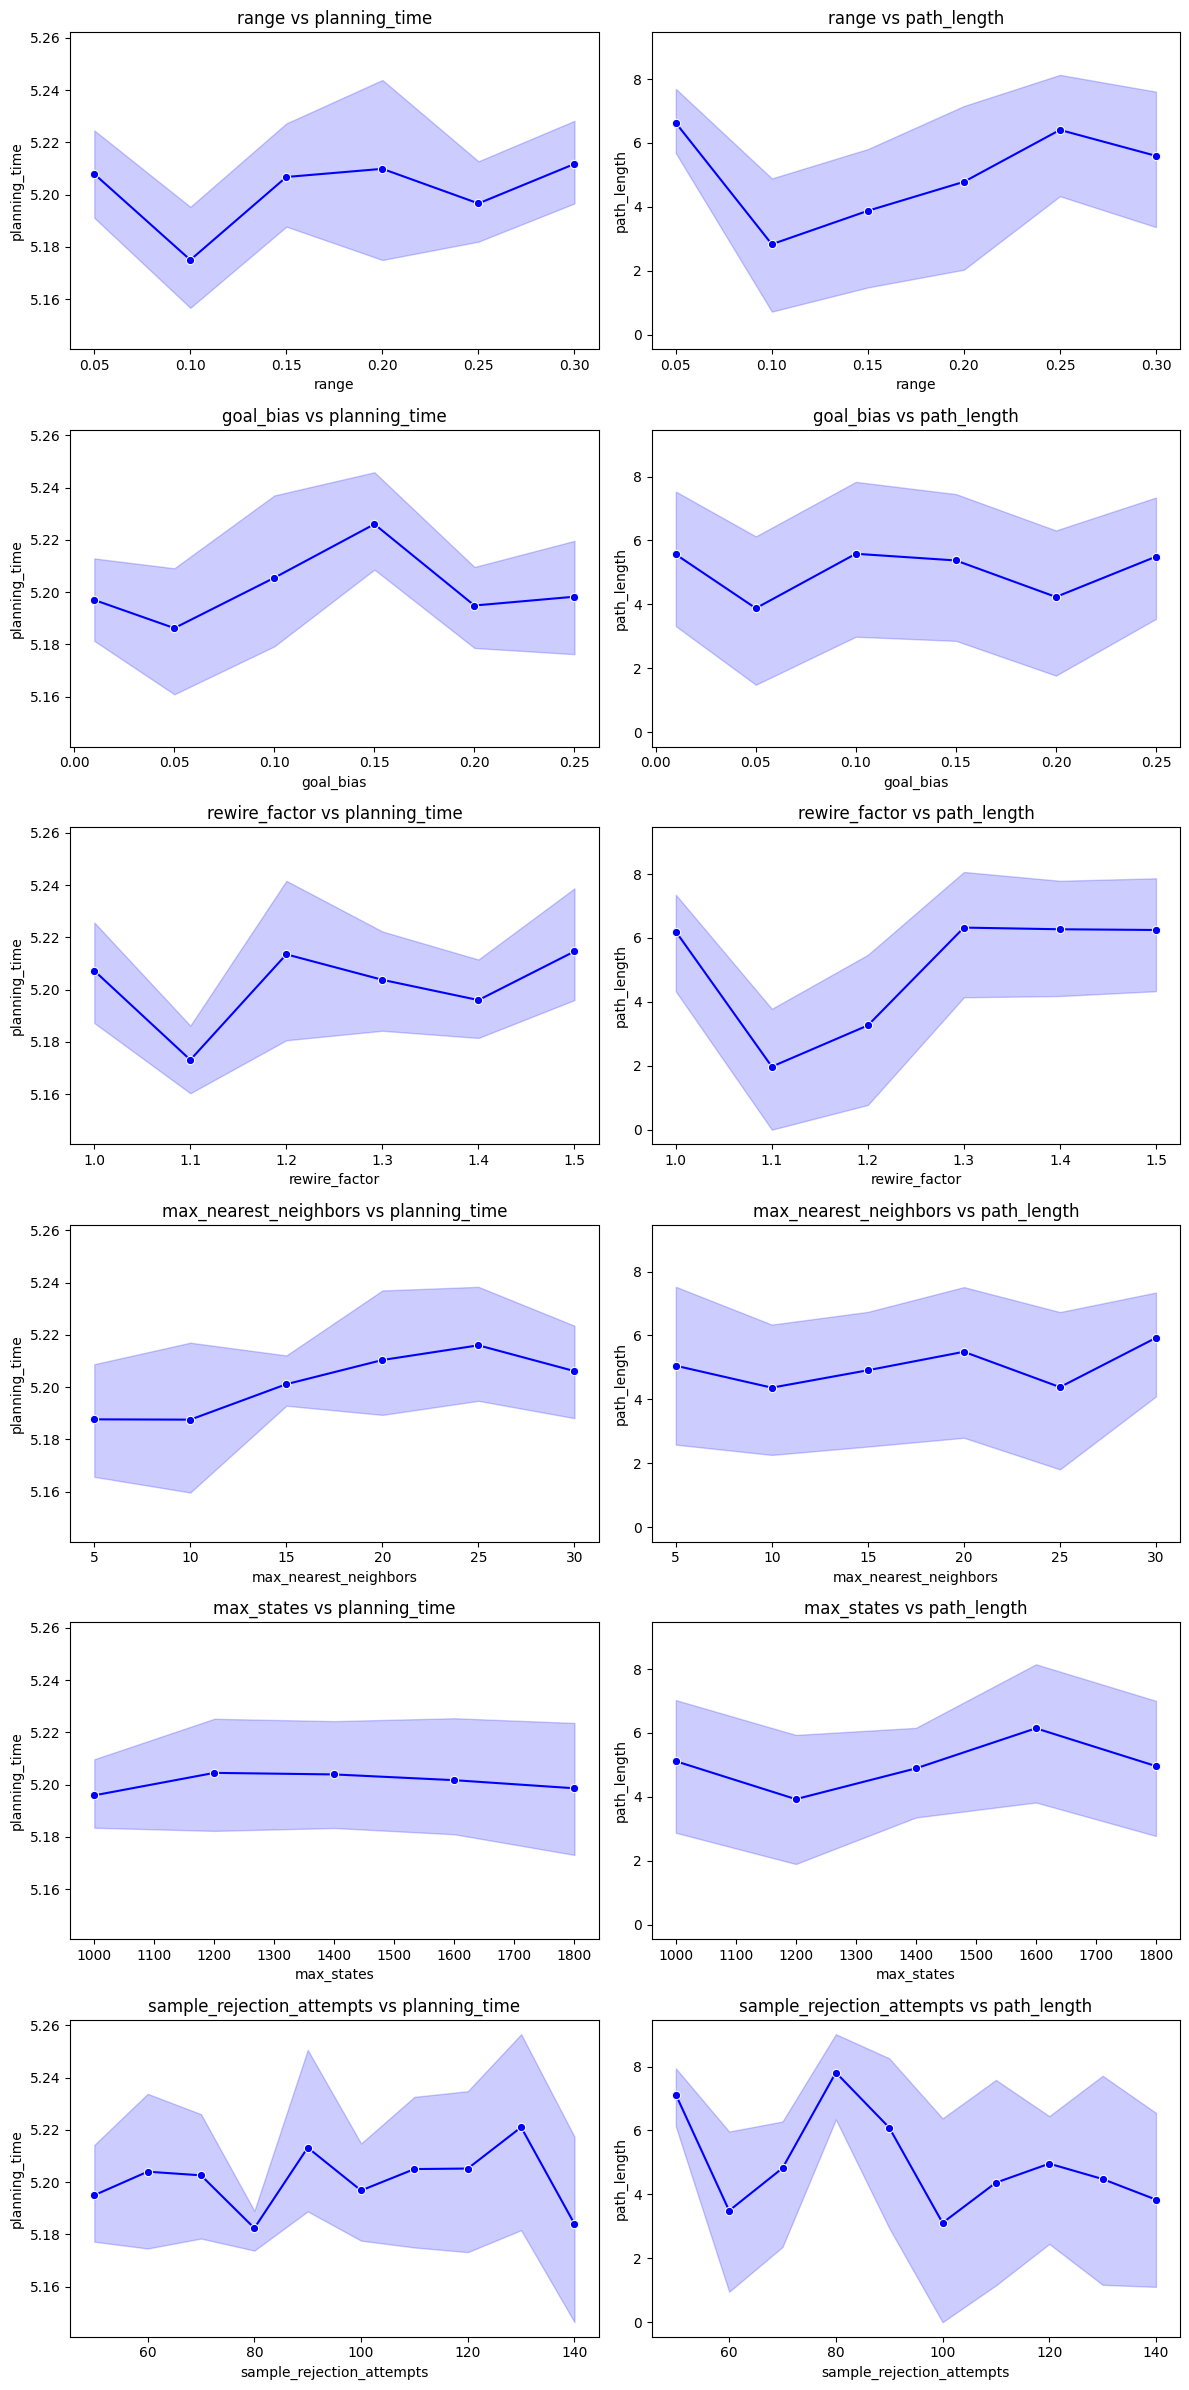

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_params_vs_goals(df, metrics=["planning_time","path_length"]):
    """
    Plots numeric parameters against planning metrics.
    - Only numeric parameters used (ignore booleans)
    - X-axis: numeric parameters
    - Y-axis: metrics
    - Sorted x-axis
    """
    # Clean column names
    df.columns = df.columns.str.strip()

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=["float64","int64"]).columns.tolist()

    # Metrics that exist in the numeric columns
    metrics = [m for m in metrics if m in numeric_cols]

    # Parameters = numeric columns that are not metrics or IDs
    exclude = ["trial_id","timestamp"] + metrics
    params = [col for col in numeric_cols if col not in exclude]

    # Grid setup
    fig, axes = plt.subplots(len(params), len(metrics), figsize=(12, 4*len(params)), sharey='col')
    if len(params) == 1:
        axes = [axes]

    for i, param in enumerate(params):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(params) > 1 else axes[j]

            # Sort by parameter
            subdf = df.sort_values(by=param)

            # Plot lineplot
            sns.lineplot(
                data=subdf,
                x=param,
                y=metric,
                marker="o",
                ax=ax,
                color="blue"
            )

            ax.set_title(f"{param} vs {metric}")
            ax.set_xlabel(param)
            ax.set_ylabel(metric)

    plt.tight_layout()
    plt.show()
csv_file = "/content/data_t7.csv"
df = pd.read_csv(csv_file, sep=",")
plot_numeric_params_vs_goals(df)


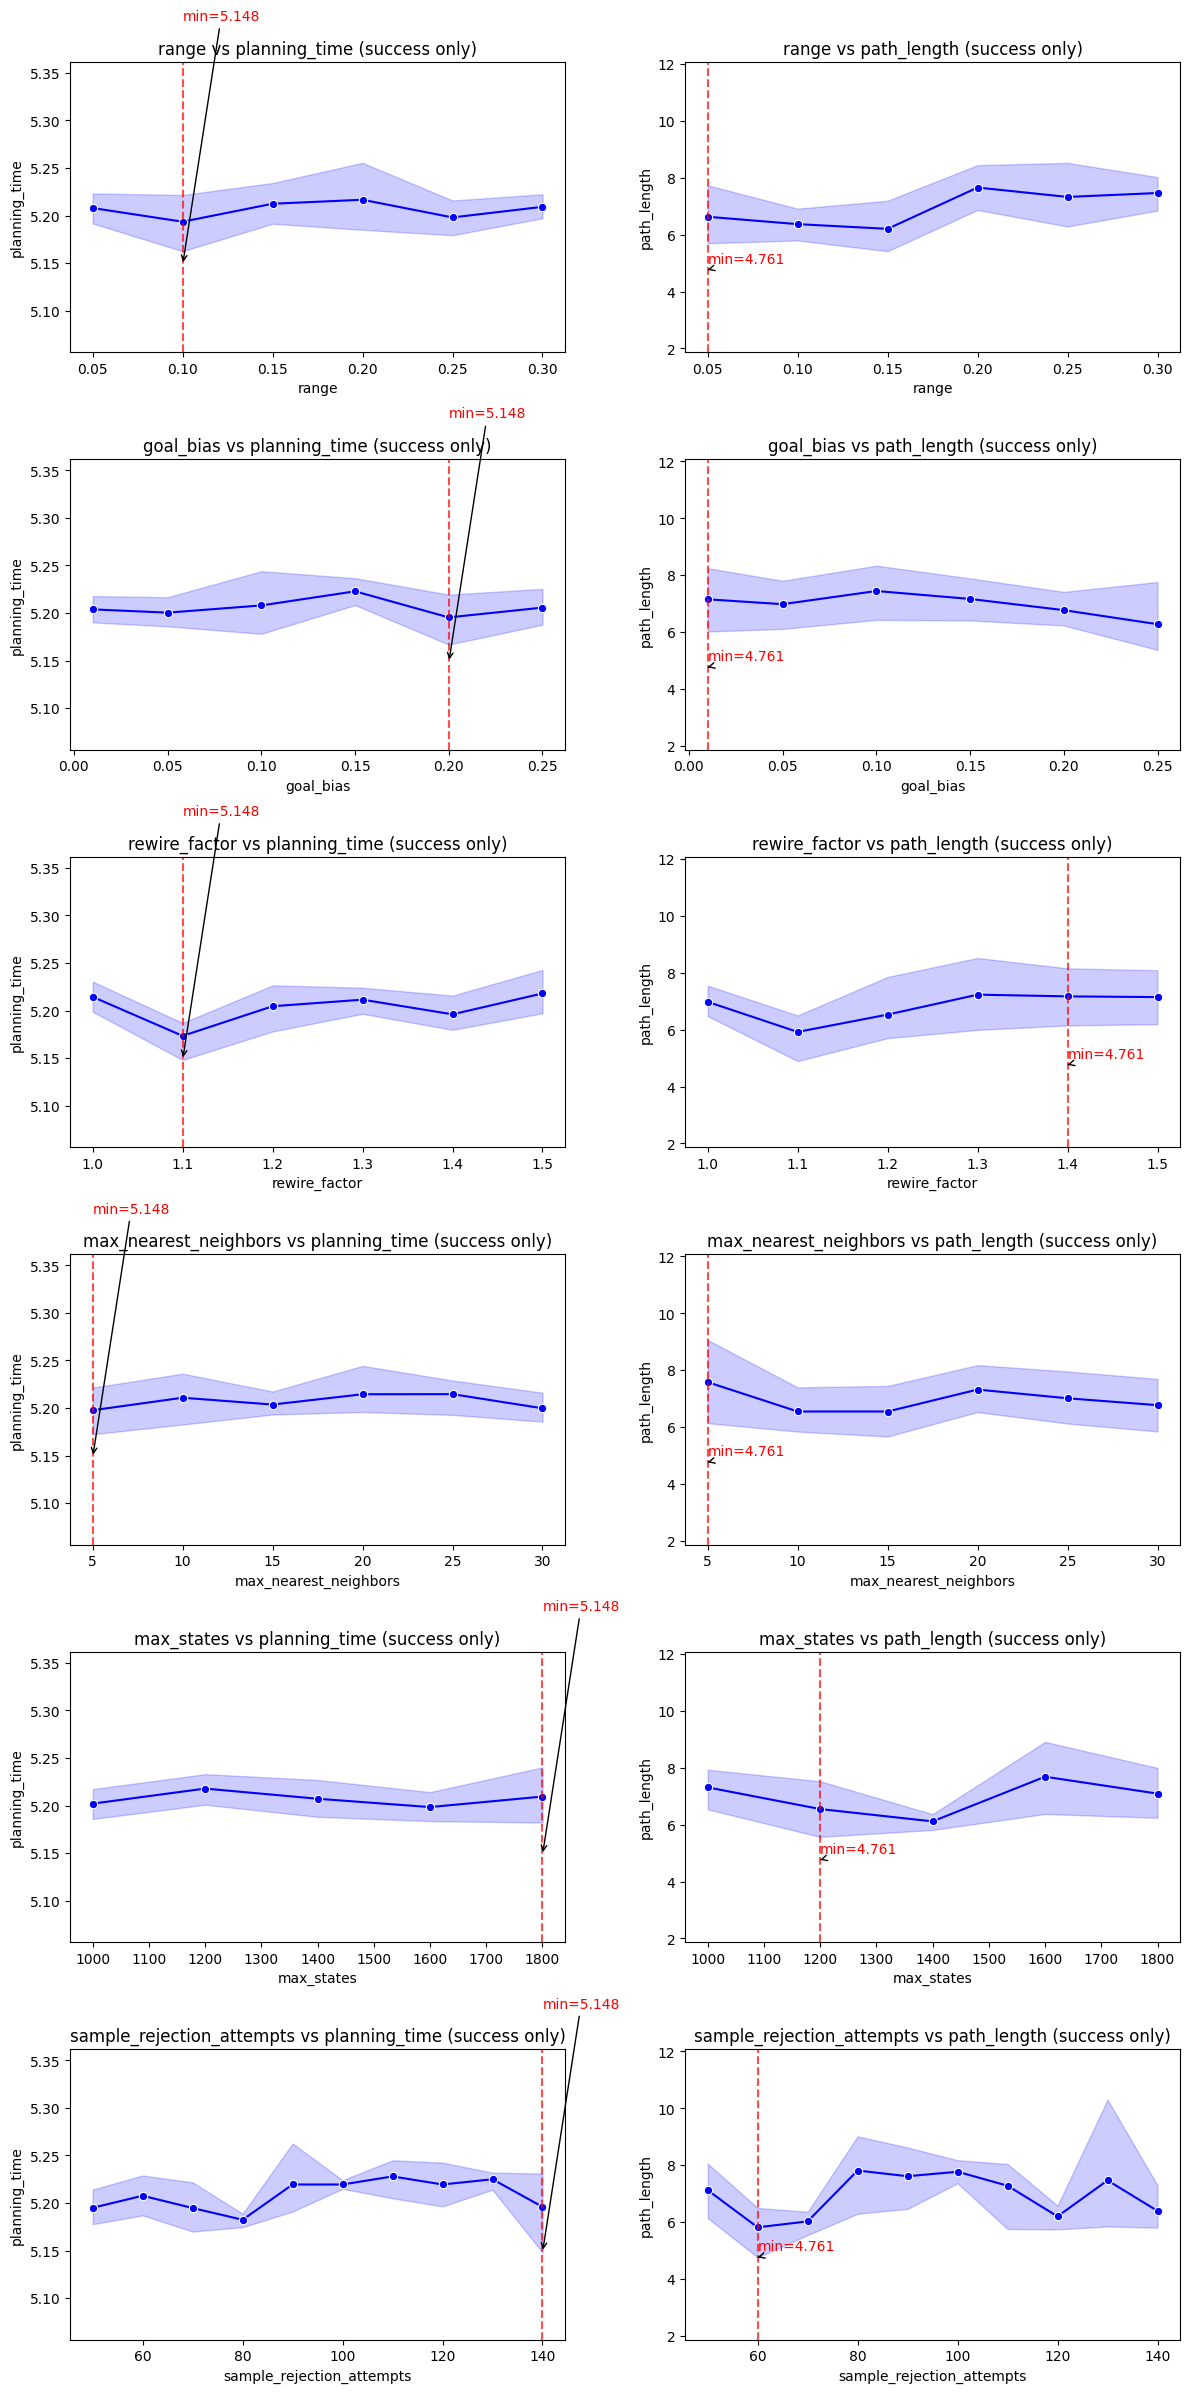

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_params_vs_goals_min_success(df, metrics=["planning_time","path_length"]):
    """
    Plots numeric parameters against metrics with:
    - Only successful trials (success == True)
    - X-axis: numeric parameters
    - Y-axis: metrics
    - Marks local minima of the metric for each parameter
    """
    # Clean column names
    df.columns = df.columns.str.strip()

    # Keep only successful trials
    df = df[df['success'] == True]

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=["float64","int64"]).columns.tolist()

    # Metrics that exist
    metrics = [m for m in metrics if m in numeric_cols]

    # Parameters = numeric columns that are not metrics or IDs
    exclude = ["trial_id","timestamp"] + metrics
    params = [col for col in numeric_cols if col not in exclude]

    # Grid setup
    fig, axes = plt.subplots(len(params), len(metrics), figsize=(12, 4*len(params)), sharey='col')
    if len(params) == 1:
        axes = [axes]
    if len(params) > 1 and len(metrics) == 1:
        axes = np.array(axes).reshape(-1, 1)

    for i, param in enumerate(params):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(params) > 1 or len(metrics) > 1 else axes

            # Sort by parameter
            subdf = df.sort_values(by=param)

            # Plot line
            sns.lineplot(
                data=subdf,
                x=param,
                y=metric,
                marker="o",
                ax=ax,
                color="blue"
            )

            # Find x-value giving minimum metric
            min_row = subdf.loc[subdf[metric].idxmin()]
            min_x = min_row[param]
            min_y = min_row[metric]

            # Plot vertical line and annotate
            ax.axvline(x=min_x, color="red", linestyle="--", alpha=0.7)
            ax.annotate(f"min={min_y:.3f}", xy=(min_x, min_y), xytext=(min_x, min_y*1.05),
                        arrowprops=dict(facecolor='red', arrowstyle="->"), color='red')

            ax.set_title(f"{param} vs {metric} (success only)")
            ax.set_xlabel(param)
            ax.set_ylabel(metric)

            # Adjust y-axis limits
            ymin, ymax = ax.get_ylim()
            y_range = ymax - ymin
            ax.set_ylim(ymin - 0.1 * y_range, ymax + 0.1 * y_range)


    plt.tight_layout()
    plt.show()



csv_file = "/content/data_t7.csv"
df = pd.read_csv(csv_file, sep=",")
optimal = plot_numeric_params_vs_goals_min_success(df)